# The Kelly Criterion and a Coin-Flipping Game

This is heavily adapted from https://www.gwern.net/Coin-flip, but following a different prompt: 

You bet on a fair coin. If you bet correctly on heads, you get $\$1$ for every $\$0.40$ bet, and if you bet correctly on tails, you get $\$1$ for every $\$0.60$ bet. You start with $\$100$; what do you do?  

## Solution via the Kelly Criterion

Let's first derive the solution without considering a profit cap or a time limit:

First, notice that we should always bet on heads; the expected value of profit in one toss is $\mathbb{E}V_H=\frac{1}{2}\cdot\frac{3}{2}-\frac{1}{2}=\frac{1}{4},$ whereas betting on tails has $\mathbb{E}V_T=\frac{1}{2}\cdot\frac{2}{3}-\frac{1}{2}=-\frac{1}{6}.$ Now, we just need to determine the quantity, which is where the Kelly Criterion comes in handy.

Let $n$ be the number of iterations we play this game. We can then write our profit as $d = (b+bpw)^{nq} + (b-bpl)^{n(1-q)},$ where $b$ is our starting amount, $p$ is the percentage of our money we bet in each round, $w$ is how much of our bet we make if we bet correctly, $q$ is our probability of betting correctly, and $l$ is how much of our bet we lose if we bet incorrectly.

To get rid of the pesky exponents, take the logarithm of the above equation: $\log{d}=nq\log{(b+bpw)}+n(1-q)\log{(b-bpl)}.$ To figure out which value $p$ maximizes our potential profit, take the derivative of the above equation with respect to $p$ and set to $0$: $\frac{\partial{d}}{\partial{p}}=\frac{nqbw}{b+bpw}-\frac{n(1-q)bl}{b-bpl}=0.$ Solving,
\begin{align*}
    \frac{qw}{1+pw}=\frac{(1-q)l}{1-pl}&\rightarrow(1+pw)(1-q)l=qw(1-pl) \\
    &\rightarrow l+pwl-ql-pwql=qw-qwpl \\
    &\rightarrow pwl = qw+ql-l \\
    &\rightarrow p = \frac{qw+ql-l}{wl}
\end{align*}

Here, we have $b=100$, $w=\frac{3}{2}$, $q=\frac{1}{2}$, and $l=1$, giving us $p=\frac{\frac{3}{4}+\frac{1}{2}-1}{\frac{3}{2}}=\frac{1}{6}$. Notice that we can derive the even money bet Kelly criterion formula $p=2q-1$ by setting $w,l=1$. Furthermore, neither the number of iterations $n$ nor the starting amount $b$ are factored into the final computation for the percentage of money bet $p$. 

## Optimality in the Markov Decision Process

Let's introduce a $\$250$ profit cap and $300$ round maximum as set in the original paper here https://arxiv.org/abs/1701.01427v1.

It is clear that the expected value per flip is maximized by maximizing the percentage bet $p$, but we usually want to hedge against the chance of going bankrupt. However, this is not the case when we have one bet left. For instance, if $n=1$, our expected gain after the bet is $\frac{1}{2}\cdot\frac{150}{6}-\frac{1}{2}\cdot\frac{100}{6}=\frac{25}{6}\approx4.1667$, yet if we bet all, our expected gain rises to $\frac{150}{2}-\frac{100}{2}=25$. And given that it is our last bet, we don't lose out on potential future earnings.

Formulated as a Markov Decision Process, this is

$$V(w,b)=\max_{x\in[0,w]}[0.5\cdot V(\min(w+1.5x,250),b-1)+0.5\cdot V(w-x,b-1)]$$

for wealth $w$ and number of bets remaining $b$. 

### OpenAI Gym Implementation

https://github.com/openai/gym/blob/master/gym/envs/toy_text/kellycoinflip.py

Let's also set the starting amount at $\$25$ rather than $\$100$ now.

In [1]:
# Modified flip function
import numpy as np

def flip(edge, np_random):
    return 1.5 if np_random.uniform() < edge else -1

def step_alt(obj, action):
    bet_in_dollars = min(action/100.0, obj.wealth)
    obj.rounds -= 1

    coinflip = flip(obj.edge, obj.np_random)
    obj.wealth = min(obj.max_wealth, obj.wealth + coinflip * bet_in_dollars)

    done = obj.wealth < 0.01 or obj.wealth == obj.max_wealth or not obj.rounds
    reward = obj.wealth if done else 0.0

    return reward, done

In [2]:
# Running the experiment 
import gym

env = gym.make('KellyCoinflip-v0')
env.__init__(25.0, edge=0.5, max_wealth=250.0, max_rounds=300)

while env.wealth < env.max_wealth:
    env.reset()
    rewards = []
    print('Starting a new game...')
    env.render()
    while env.rounds > 0:
        reward, done = step_alt(env, env.wealth*100/6) # bet w 16.66667% KC
        rewards.append(env.wealth)
        if done:
            env.render()
            break
        if env.rounds % 10 == 9:
            env.render()
    print('Reward: %d' % reward)

Starting a new game...
Current wealth:  25.0 ; Rounds left:  300
Current wealth:  20.833333333333332 ; Rounds left:  299
Current wealth:  25.550687918120126 ; Rounds left:  289
Current wealth:  20.890804898853435 ; Rounds left:  279
Current wealth:  25.62117294378908 ; Rounds left:  269
Current wealth:  13.965623338302677 ; Rounds left:  259
Current wealth:  11.418601071967572 ; Rounds left:  249
Current wealth:  47.26400421711957 ; Rounds left:  239
Current wealth:  57.966135432592104 ; Rounds left:  229
Current wealth:  106.63737381055049 ; Rounds left:  219
Current wealth:  196.17539462217303 ; Rounds left:  209
Current wealth:  250.0 ; Rounds left:  207
Reward: 250


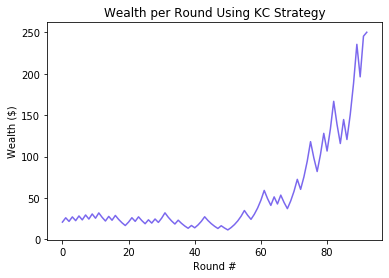

In [4]:
# Visualize earnings
import matplotlib.pyplot as plt
plt.plot(rewards, color='mediumslateblue')
plt.title('Wealth per Round Using KC Strategy')
plt.xlabel('Round #')
plt.ylabel('Wealth ($)')
plt.show()

### Approach: Dynamic Programming

We'll first take the top-down approach (memoization). We store $w\cdot b$ elements with this technique and each call takes $w$ time, for a total time complexity of $\mathcal{O}(w^2b)$.

In [5]:
import numpy as np
import time

def F(w, x, b):
    return 0.5*V(min(w+1.5*x,250), b-1) + 0.5*V(w-x, b-1)

def V(w, b):
    if b>0 and w>0 and w<250:
        if (w,b) in payoff_dict:
            return payoff_dict[(w,b)]
        else:
            bets = np.arange(0, w, 0.01).tolist()
            returns = [F(w,x,b) for x in bets]
    else:
        returns = [w]
    bets_dict[(w,b)] = np.argmax(returns) * 0.01
    payoff_dict[(w,b)] = max(returns)
    return payoff_dict[(w,b)]

def render(w, b):
    processing_time = time.process_time()
    best_gain = V(w, b)
    best_bets = bets_dict[(w,b)]
    print("With %0.2f and %d rounds, bet %0.2f with expected score %0.2f." %(w, b, best_bets, best_gain))
    print("This procedure took %0.4f seconds for processing." %(time.process_time() - processing_time))

# Maintain a global storage for memoized answers to subproblems.
payoff_dict = {}
bets_dict = {}

In [6]:
render(25, 0)
render(25, 1)
render(25, 2)

With 25.00 and 0 rounds, bet 0.00 with expected score 25.00.
This procedure took 0.0002 seconds for processing.
With 25.00 and 1 rounds, bet 24.99 with expected score 31.25.
This procedure took 0.0985 seconds for processing.
With 25.00 and 2 rounds, bet 24.99 with expected score 39.06.
This procedure took 351.8831 seconds for processing.


To optimize, let's utilize parallel processing.

In [7]:
# Synchronous version
import multiprocessing

def get_score():
    with multiprocessing.Pool() as pool:
        pool.starmap(render, [(25, rounds) for rounds in range(3)])
        
payoff_dict = {}
bets_dict = {}

In [8]:
get_score()

With 25.00 and 0 rounds, bet 0.00 with expected score 25.00.
This procedure took 0.0067 seconds for processing.
With 25.00 and 1 rounds, bet 24.99 with expected score 31.25.
This procedure took 0.0927 seconds for processing.
With 25.00 and 2 rounds, bet 24.99 with expected score 39.06.
This procedure took 346.7385 seconds for processing.


In [9]:
# Asynchronous version
def render(i, w, b):
    processing_time = time.process_time()
    best_gain = V(w, b)
    best_bets = bets_dict[(w,b)]
    print("With %0.2f and %d rounds, bet %0.2f with expected score %0.2f." %(w, b, best_bets, best_gain))
    print("This procedure took %0.4f seconds for processing." %(time.process_time() - processing_time))
    return i

payoff_dict = {}
bets_dict = {}

with multiprocessing.Pool() as pool:
    result_objects = [pool.starmap_async(render, [(i, 25, i) for i in range(3)])]
    results = [r.get()[1] for r in result_objects]

pool.close()
pool.join()

With 25.00 and 0 rounds, bet 0.00 with expected score 25.00.
This procedure took 0.0059 seconds for processing.
With 25.00 and 1 rounds, bet 24.99 with expected score 31.25.
This procedure took 0.0997 seconds for processing.
With 25.00 and 2 rounds, bet 24.99 with expected score 39.06.
This procedure took 315.6204 seconds for processing.


Now, let's take the bottom-up approach (tabulation).

### Approach: Monte Carlo Simulations

In [10]:
import numpy as np

def game(strategy, wealth, bets_left):
    if bets_left > 0:
        bet = strategy(wealth, bets_left)
        wealth -= bet
        flip = np.random.binomial(1, 0.5, 1)[0]
        winnings = 2.5*bet*flip
        wealth = min(wealth+winnings, 250)
        return game(strategy, wealth, bets_left-1)
    else:
        return wealth
    
def simulate_game(strategy, wealth, bets_left, iterations):
    return np.mean(np.repeat(game(strategy, wealth, bets_left),iterations))

def kelly(wealth, bets_left):
    return wealth/6

def smarter_kelly(wealth, bets_left):
    if wealth == 250:
        return 0
    return wealth/6

def random(wealth, bets_left):
    return np.random.choice(np.linspace(start=0, stop=wealth, num=int(100*wealth+1)), 1)[0]
        

In [11]:
print(simulate_game(kelly,25,0,10))
print(simulate_game(smarter_kelly,25,0,10))
print(simulate_game(random,25,0,10))

25.0
25.0
25.0


In [12]:
print(simulate_game(kelly,25,1,10))
print(simulate_game(smarter_kelly,25,1,10))
print(simulate_game(random,25,1,10))

31.25
31.25
27.909999999999997


In [13]:
print(simulate_game(kelly,25,150,10))
print(simulate_game(smarter_kelly,25,150,10))
print(simulate_game(random,25,150,10))

250.0
105.49515012229665
0.0


In [14]:
print(simulate_game(kelly,25,300,10))
print(simulate_game(smarter_kelly,25,300,10))
print(simulate_game(random,25,300,10))

64.65566360325306
250.0
0.0


## Exact Value Function

In [15]:
#TODO: Need to derive equation

!pip install repoze.lru
from scipy.stats import binom
import numpy as np
from repoze.lru import lru_cache

def V(w, b, m=250):
    if w>=250:
        return 250
    if w<=0:
        return 0
    if b==0:
        return w
    else:
        try:
            j = binom.ppf(float(w)/float(m), b, 0.5)
            return 1.2**b * 1.5**-j * (w + m/2 *
                sum(np.multiply(binom.cdf(list(map(lambda x2:x2-1, range(0,int(j+1)))),b,0.5),
                    list(map(lambda x: 1.5**x, list(reversed(range(0, int(j+1)))))))))
        except ValueError:
            print("Error:", (w,b,m))

@lru_cache(None)
def VPplan(w, b):
    # optimization: short-circuit
    if w<=0 or w>=250:
        return 0
    else:
        if b==0:
            return w
        else:
            possibleBets = map(lambda pb: float(pb)/100.0, range(0*100,int((w*100)+1),1))
            returns = list(map(lambda pb: 0.6*V(w+pb, b-1) + 0.4*V(w-pb,b-1), possibleBets))
            return float(returns.index(max(returns)))/100.0

In [16]:
import gym
env = gym.make('KellyCoinflip-v0')

## play 5 games and calculate mean reward:
rewards = []
for n in range(5):
    done = False
    reward = 0
    while not done:
        w = env._get_obs()[0][0]
        b = env._get_obs()[1]
        bet = VPplan(w, b)
        results = env.step(bet*100)
        if env.rounds % 10 == 9:
            print("Game %d with %f wealth and %d bets left: Bet %f." %(n, w, b, bet))
        reward = reward+results[1]
        done = results[2]
    rewards.append(reward)
    env.reset()

print(sum(rewards)/len(rewards))

Game 0 with 25.000000 wealth and 300 bets left: Bet 0.400000.
Game 0 with 33.050000 wealth and 290 bets left: Bet 3.140000.
Game 0 with 38.700000 wealth and 280 bets left: Bet 3.560000.
Game 0 with 53.610000 wealth and 270 bets left: Bet 4.440000.
Game 0 with 36.420000 wealth and 260 bets left: Bet 3.520000.
Game 0 with 68.310000 wealth and 250 bets left: Bet 2.540000.
Game 0 with 50.180000 wealth and 240 bets left: Bet 4.530000.
Game 0 with 58.530000 wealth and 230 bets left: Bet 5.050000.
Game 0 with 47.590000 wealth and 220 bets left: Bet 4.580000.
Game 0 with 55.990000 wealth and 210 bets left: Bet 5.170000.
Game 0 with 54.570000 wealth and 200 bets left: Bet 5.210000.
Game 0 with 53.080000 wealth and 190 bets left: Bet 5.240000.
Game 0 with 86.470000 wealth and 180 bets left: Bet 4.730000.
Game 0 with 102.260000 wealth and 170 bets left: Bet 7.460000.
Game 0 with 132.870000 wealth and 160 bets left: Bet 7.870000.
Game 0 with 164.590000 wealth and 150 bets left: Bet 7.500000.
Game 

Game 4 with 115.050000 wealth and 100 bets left: Bet 9.950000.
Game 4 with 175.190000 wealth and 90 bets left: Bet 9.180000.
Game 4 with 222.680000 wealth and 80 bets left: Bet 5.240000.
Game 4 with 235.030000 wealth and 70 bets left: Bet 3.540000.
Game 4 with 238.440000 wealth and 60 bets left: Bet 3.130000.
Game 4 with 245.890000 wealth and 50 bets left: Bet 1.440000.
Game 4 with 247.920000 wealth and 40 bets left: Bet 0.890000.
Game 4 with 249.830000 wealth and 30 bets left: Bet 0.110000.
250.0


### Approximating the Exact Value Function with Machine Learning

#TODO: POMDPS